## Data Ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

In [2]:
n_samples = 1000

x, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)

In [3]:
len(x), len(y)

(1000, 1000)

In [4]:
x[:5]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343]])

In [5]:
y[:5]

array([1, 1, 1, 1, 0])

In [6]:
import pandas as pd
circles = pd.DataFrame({"X1" : x[:,0],
                        "X2" : x[:,1],
                        "label" : y})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


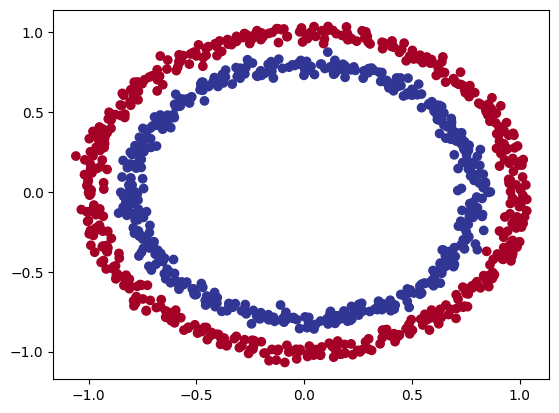

In [7]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x = x[:,0],
            y = x[:,1],
            c = y,
            cmap = plt.cm.RdYlBu)
plt.show()

In [8]:
x.shape, y.shape

((1000, 2), (1000,))

In [9]:
x_sample = x[0]
y_sample = y[0]

print(f"Sample X : {x_sample.shape}")
print(f"Sample Y : {y_sample.shape}")

Sample X : (2,)
Sample Y : ()


## Create train and test splits

In [10]:
import torch
torch.__version__

'2.3.1+cu121'

In [11]:
x.dtype, y.dtype

(dtype('float64'), dtype('int64'))

In [12]:
type(x), type(y)

(numpy.ndarray, numpy.ndarray)

In [13]:
# Turn data into tensors
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

type(x), type(y)

(torch.Tensor, torch.Tensor)

In [14]:
 x[:5], y[:5], x.dtype, y.dtype

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]),
 torch.float32,
 torch.float32)

In [15]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state = 42)

In [16]:
len(x_train), len(x_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Building a model

1. Setup Device (GPU)
2. Construct a model
3. Define loss function
4. Create training and test loop

In [17]:
# import PyTorch and nn
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

#### Construct Model

1. nn.Module
2. create nn.Linear()
3. Defines a forward() method
4. Instatiate an instance of our model class and send it to the target device

In [18]:
x_train.shape

torch.Size([800, 2])

In [19]:
# 1.
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # Creating nn.Linear layers
    self.layer_1 = nn.Linear(in_features = 2, out_features = 5)
    self.layer_2 = nn.Linear(in_features = 5, out_features = 1)

    # self.two_linear_layers = nn.Sequential(
    #     nn.Linear(in_features = 2, out_features = 5),
    #     nn.Linear(in_features = 5, out_features = 1)
    # )

  # Define forward() method
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output
    # return self.two_liear_layers(x)

In [20]:
# Instantiate an instance
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
next(model_0.parameters()).device

device(type='cpu')

In [22]:
# Let's replicate the model above using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)

model_0


Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [23]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.4654, -0.2114],
                      [ 0.4615, -0.1131],
                      [-0.2940,  0.0555],
                      [-0.2106,  0.3228],
                      [ 0.6999, -0.6988]])),
             ('0.bias', tensor([-0.1260,  0.3261,  0.6274,  0.2749, -0.3323])),
             ('1.weight',
              tensor([[-0.3910, -0.1967,  0.0192,  0.1075, -0.2757]])),
             ('1.bias', tensor([0.3039]))])

In [24]:
with torch.inference_mode():
  untrained_preds = model_0(x_test.to(device))
print(f"Number of predictions : {len(untrained_preds)}, Shape : {untrained_preds.shape}")
print(f"Lenght of test samples : {len(x_test)}, Shape : {x_test.shape}")
print(f"\n First 10 predictions : \n{torch.round(untrained_preds[:10])}")
print(f"\n First 10 labels : {y_test[:10]}")

Number of predictions : 200, Shape : torch.Size([200, 1])
Lenght of test samples : 200, Shape : torch.Size([200, 2])

 First 10 predictions : 
tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]])

 First 10 labels : tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [25]:
x_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

#### Setup loss function and optimizers

In [26]:
list(model_0.parameters())

[Parameter containing:
 tensor([[-0.4654, -0.2114],
         [ 0.4615, -0.1131],
         [-0.2940,  0.0555],
         [-0.2106,  0.3228],
         [ 0.6999, -0.6988]], requires_grad=True),
 Parameter containing:
 tensor([-0.1260,  0.3261,  0.6274,  0.2749, -0.3323], requires_grad=True),
 Parameter containing:
 tensor([[-0.3910, -0.1967,  0.0192,  0.1075, -0.2757]], requires_grad=True),
 Parameter containing:
 tensor([0.3039], requires_grad=True)]

In [27]:
loss_fn = nn.BCEWithLogitsLoss() # BCE-> Binary CrossEntropy

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [28]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## Train Model

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss Backward (Backpropagation)
5. optimizer step (Gradient Descent)

Our model outputs are going to be raw **logits**
* Raw logits -> prediction probabilities -> prediction labels

* Logits : The raw predictions which come out of the last layer of the neural network. (It didn't pass any activation function like (softmax,sigmoid.....))

In [29]:
# View the first 5 logits
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(x_test.to(device))[:5]
y_logits

tensor([[0.6987],
        [0.7403],
        [0.4088],
        [0.7815],
        [0.1220]])

In [30]:
# use sigmoid function on our model logits to turn into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6679],
        [0.6771],
        [0.6008],
        [0.6860],
        [0.5305]])

In [31]:
y_preds = torch.round(y_pred_probs)

In [32]:
y_preds_labels = torch.round(torch.sigmoid(model_0(x_test.to(device))[:5]))

# logits -> probability -> labels
print(torch.eq(y_preds.squeeze(),y_preds_labels.squeeze())) # get rid extra dimention

y_preds.squeeze()


tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

In [33]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### Building training and test loop

In [34]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put the data to target device
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train() # train mode

    # 1. Forward pass
    y_logits = model_0(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss/ accuracy
    loss = loss_fn(y_logits,
                    y_train)

    acc = accuracy_fn(y_true = y_train,
                        y_pred = y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (calclulate gradient)
    loss.backward()

    # 5. optimizer step (update parameters)
    optimizer.step()


    ### Testing
    model_0.eval() #
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)

        # Print
        if epoch % 10 == 0:
            print(f"Epoch : {epoch} | Loss : {loss:.5f}, Acc : {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc : {test_acc:.2f}%")


Epoch : 0 | Loss : 0.71958, Acc : 50.00% | Test Loss: 0.72639, Test acc : 50.00%
Epoch : 10 | Loss : 0.70366, Acc : 58.75% | Test Loss: 0.71012, Test acc : 57.00%
Epoch : 20 | Loss : 0.69763, Acc : 54.00% | Test Loss: 0.70359, Test acc : 50.00%
Epoch : 30 | Loss : 0.69527, Acc : 52.50% | Test Loss: 0.70080, Test acc : 50.00%
Epoch : 40 | Loss : 0.69431, Acc : 51.88% | Test Loss: 0.69948, Test acc : 47.50%
Epoch : 50 | Loss : 0.69388, Acc : 51.62% | Test Loss: 0.69877, Test acc : 47.50%
Epoch : 60 | Loss : 0.69366, Acc : 51.12% | Test Loss: 0.69833, Test acc : 46.00%
Epoch : 70 | Loss : 0.69353, Acc : 51.12% | Test Loss: 0.69801, Test acc : 46.50%
Epoch : 80 | Loss : 0.69344, Acc : 51.25% | Test Loss: 0.69776, Test acc : 47.00%
Epoch : 90 | Loss : 0.69338, Acc : 50.75% | Test Loss: 0.69755, Test acc : 47.00%


In [35]:
## Make prediction
import requests
from pathlib import Path

# Download helper function
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download...")
else:
    print("Downloading helper_functions.py...")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)


from helper_functions import plot_decision_boundary, plot_predictions






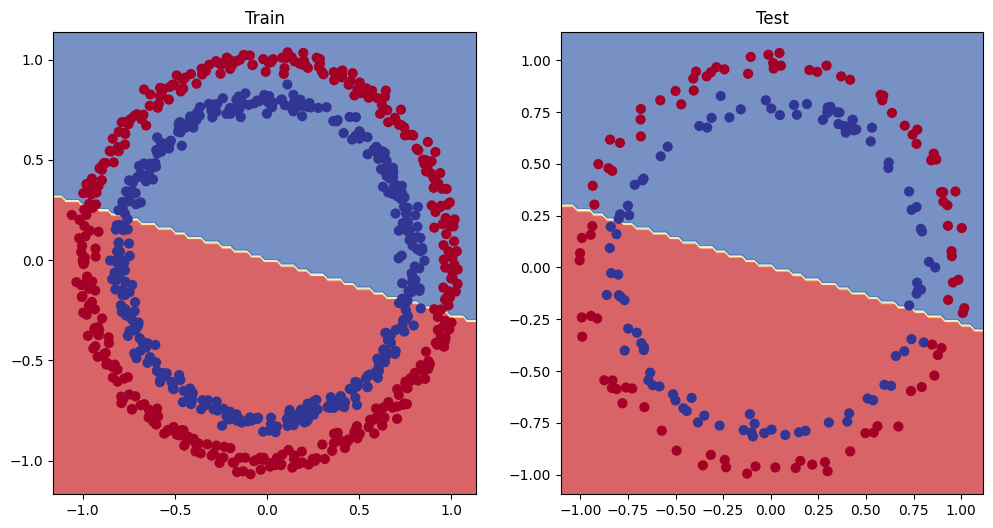

In [36]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, x_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, x_test, y_test)
plt.show()

## Improving model

In [37]:
x_train[:5]

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        [-0.9666, -0.2256],
        [-0.1666,  0.7994]])

In [38]:
# Model Architecture
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
        self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
        self.layer_3 = nn.Linear(in_features = 10, out_features = 1)


    def forward(self,x):
        z = self.layer_1(x)
        z = self.layer_2(z)
        z = self.layer_3(z)
        return z

In [39]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [40]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [41]:
# Loss function
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer function
optimizer = torch.optim.SGD(params = model_1.parameters(),
                    lr = 0.01)

In [42]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [43]:
# Writing training and evaluation loop for model_1
epochs = 1000

for epoch in range(epochs):
    model_1.train() # train Mode

    # 1. Forward pass
    y_logits = model_1(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. calculate the loss / acc(optional)
    loss = loss_fn(y_logits, y_train)

    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Gradient Decent
    optimizer.step()

    ### Testing
    model_1.eval() # Evaluating mode
    with torch.inference_mode():

        # 1. Forward pass
        test_logits = model_1(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. calculate the loss / accuracy
        test_loss = loss_fn(test_logits,y_test)

        test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

        # Print info
        if epoch % 100 == 0:
            print(f"Epoch : {epoch} | Loss : {loss:.5f}, Acc : {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc : {test_acc:.2f}%")





Epoch : 0 | Loss : 0.69396, Acc : 50.88% | Test Loss: 0.69261, Test acc : 51.00%
Epoch : 100 | Loss : 0.69369, Acc : 50.25% | Test Loss: 0.69269, Test acc : 50.00%
Epoch : 200 | Loss : 0.69351, Acc : 50.12% | Test Loss: 0.69282, Test acc : 49.50%
Epoch : 300 | Loss : 0.69339, Acc : 50.50% | Test Loss: 0.69295, Test acc : 49.00%
Epoch : 400 | Loss : 0.69329, Acc : 50.38% | Test Loss: 0.69309, Test acc : 48.50%
Epoch : 500 | Loss : 0.69322, Acc : 49.88% | Test Loss: 0.69322, Test acc : 49.50%
Epoch : 600 | Loss : 0.69317, Acc : 49.50% | Test Loss: 0.69335, Test acc : 53.00%
Epoch : 700 | Loss : 0.69313, Acc : 49.38% | Test Loss: 0.69347, Test acc : 50.50%
Epoch : 800 | Loss : 0.69309, Acc : 50.00% | Test Loss: 0.69358, Test acc : 51.00%
Epoch : 900 | Loss : 0.69307, Acc : 50.62% | Test Loss: 0.69368, Test acc : 47.50%


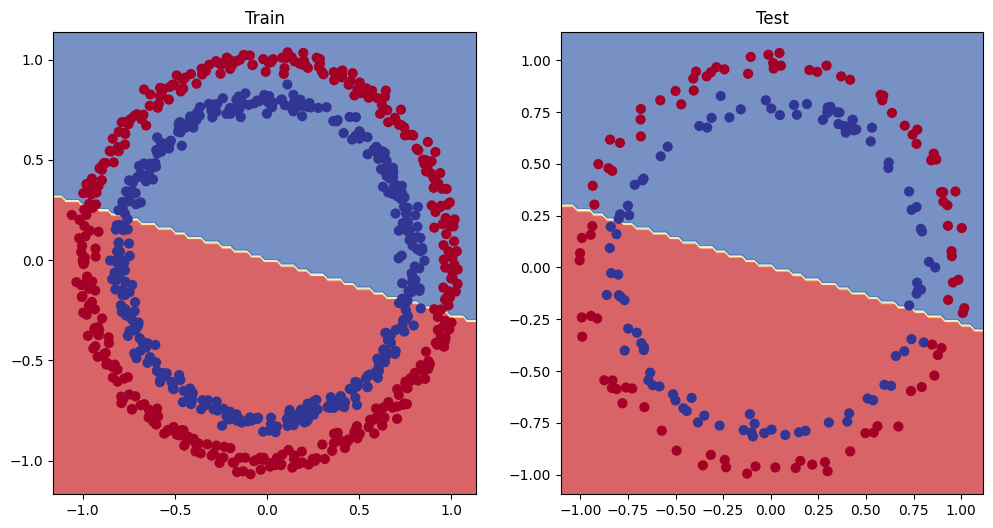

In [44]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, x_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, x_test, y_test)
plt.show()

## Non-Linearity

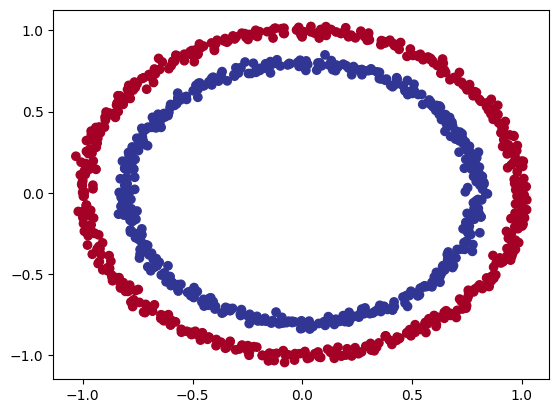

In [62]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

x,y = make_circles(n_samples,
                   noise = 0.02,
                   random_state = 42)

plt.scatter(x[:,0],x[:,1],c = y, cmap = plt.cm.RdYlBu)

In [63]:
import torch
from sklearn.model_selection import train_test_split

x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)

x_train[:5], y[:5]

(tensor([[ 0.6483, -0.4748],
         [ 0.6464, -0.7356],
         [-1.0020, -0.1328],
         [-0.9692, -0.2252],
         [-0.1676,  0.7936]]),
 tensor([1., 1., 1., 1., 0.]))

In [64]:
from torch import nn
class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
        self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
        self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
        self.relu = nn.ReLU() # non-linear activation function


    def forward(self,x):
        z = self.layer_1(x)
        z = self.relu(z)
        z = self.layer_2(z)
        z = self.relu(z)
        z = self.layer_3(z)

        return z


In [65]:
model_2 = CircleModelV3().to("cpu")
model_2

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [66]:
model_2.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [67]:
# setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_2.parameters(),
                            lr = 0.1)

In [68]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

x_train, y_train = x_train.to("cpu"), y_train.to("cpu")
x_test, y_test = x_test.to("cpu"), y_test.to("cpu")

epochs = 1000


for epoch in range(epochs):
    model_2.train() # train mode

    # 1. Forward pass
    y_logits = model_2(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2 Calculate loss and accuracy
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)

    # 3. Optimizer grad zero
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. step the optimizer
    optimizer.step()

    ## Testing
    with torch.inference_mode():
        model_2.eval()

        # 1. Forward pass
        test_logits = model_2(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss and accuracy
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)

        if epoch % 100 == 0:
            print(f"Epoch : {epoch} | Loss : {loss:.5f}, Acc : {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc : {test_acc:.2f}%")


Epoch : 0 | Loss : 0.69295, Acc : 50.00% | Test Loss: 0.69313, Test acc : 50.00%
Epoch : 100 | Loss : 0.69116, Acc : 52.75% | Test Loss: 0.69091, Test acc : 53.00%
Epoch : 200 | Loss : 0.68980, Acc : 53.00% | Test Loss: 0.68923, Test acc : 55.00%
Epoch : 300 | Loss : 0.68797, Acc : 53.00% | Test Loss: 0.68697, Test acc : 56.50%
Epoch : 400 | Loss : 0.68516, Acc : 52.75% | Test Loss: 0.68372, Test acc : 56.50%
Epoch : 500 | Loss : 0.68107, Acc : 52.62% | Test Loss: 0.67879, Test acc : 56.50%
Epoch : 600 | Loss : 0.67518, Acc : 53.87% | Test Loss: 0.67189, Test acc : 56.50%
Epoch : 700 | Loss : 0.66651, Acc : 57.75% | Test Loss: 0.66175, Test acc : 59.00%
Epoch : 800 | Loss : 0.65148, Acc : 63.62% | Test Loss: 0.64551, Test acc : 67.50%
Epoch : 900 | Loss : 0.62331, Acc : 74.25% | Test Loss: 0.61848, Test acc : 77.50%


In [71]:
# Make prediction
model_2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(x_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

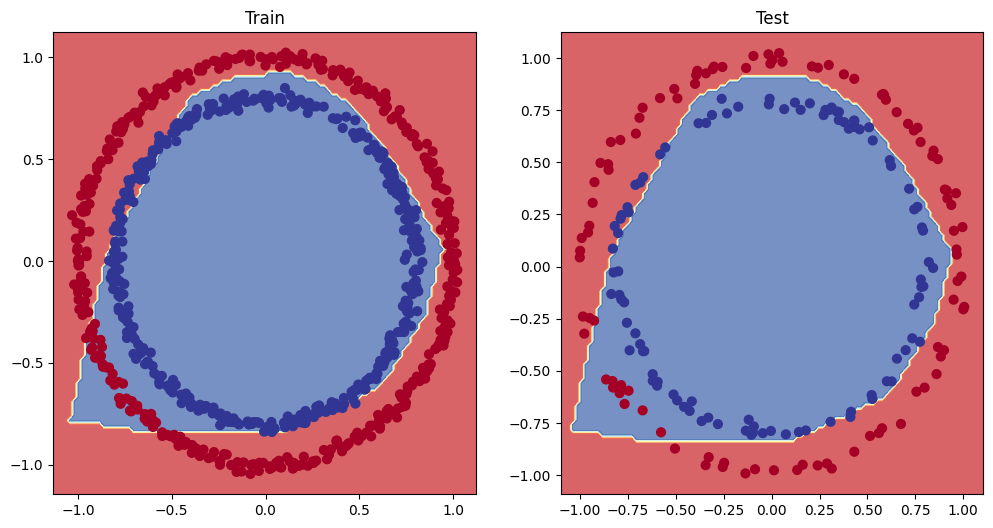

In [72]:
# plot decision boundaries

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2, x_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2, x_test, y_test)

# Multiclass Classification

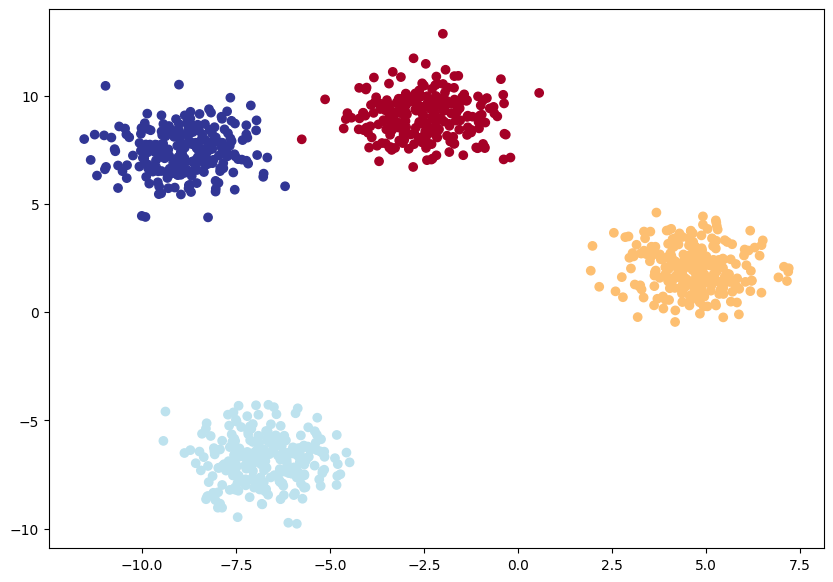

In [113]:
# Import Dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

x_blob, y_blob = make_blobs(n_samples = 1000,
                            centers = NUM_CLASSES,
                            random_state = RANDOM_SEED)

# Turn data intor tensors
x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Split data
x_train, x_test, y_train, y_test = train_test_split(x_blob,y_blob,test_size = 0.2, random_state = RANDOM_SEED)

# Plot
plt.figure(figsize=(10,7))
plt.scatter(x_blob[:,0],x_blob[:,1],c = y_blob,cmap = plt.cm.RdYlBu)
plt.show()


In [114]:
class BlobModel(nn.Module):
    def __init__(self, input_features , output_features, hidden_units = 8):
        super().__init__()

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units , out_features = output_features)
        )


    def forward(self,x):
        return self.linear_layer_stack(x)

In [115]:
model_4 = BlobModel(input_features = 2,
                   output_features = 4,
                   hidden_units = 8).to("cpu")

model_4.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]])),
             ('linear_layer_stack.0.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691])),
             ('linear_layer_stack.2.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003],
                      [ 0.2730,  0.0588, -0.1148,  0.2185,  0.0551,  0.2857,  0.0387, -0.1115],
                      [ 0.0950, -0.0959,  0.1488,  0.3157,  0.2044, -0.1546,  0.2041,  0.0633],
                      [ 0.1795, -0.2155, -0.3500, -0.1366, -0.2712,  0.2901,  0.1018,  0.1464],
                      [ 0.1118, -0.0062,  0.276

In [116]:
!pip install torchinfo

from torchinfo import summary

summary(model_4, input_size=(1, 2)) # Pass the input size (batch_size , features)

Layer (type:depth-idx)                   Output Shape              Param #
BlobModel                                [1, 4]                    --
├─Sequential: 1-1                        [1, 4]                    --
│    └─Linear: 2-1                       [1, 8]                    24
│    └─ReLU: 2-2                         [1, 8]                    --
│    └─Linear: 2-3                       [1, 8]                    72
│    └─ReLU: 2-4                         [1, 8]                    --
│    └─Linear: 2-5                       [1, 4]                    36
Total params: 132
Trainable params: 132
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [117]:
## loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_4.parameters(),
                            lr = 0.1)


In [118]:
# Building training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

x_train, y_train = x_train.to("cpu"), y_train.to("cpu")
x_test, y_test = x_test.to("cpu"), y_test.to("cpu")

epochs = 100

for epoch in range(epochs):
    model_4.train() # train mode

    # Forward pass
    y_logits = model_4(x_train)
    y_preds = torch.softmax(y_logits, dim = 1).argmax(dim=1)

    # calculate loss / acc
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_preds)

    # Optimizer
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Optimizer
    optimizer.step()

    ### Testing

    # Forward
    model_4.eval()
    with torch.inference_mode():

        # Forward
        test_logits = model_4(x_test)
        test_preds = torch.softmax(test_logits, dim = 1).argmax(dim=1)

        # Calculate loss/ acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_preds)

        if epoch % 10 == 0:
            print(f"Epoch : {epoch} | Loss : {loss:.5f}, Acc : {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc : {test_acc:.2f}%")




Epoch : 0 | Loss : 1.15229, Acc : 38.62% | Test Loss: 1.06802, Test acc : 44.50%
Epoch : 10 | Loss : 0.62249, Acc : 98.75% | Test Loss: 0.63935, Test acc : 99.50%
Epoch : 20 | Loss : 0.38991, Acc : 99.75% | Test Loss: 0.39338, Test acc : 100.00%
Epoch : 30 | Loss : 0.20595, Acc : 99.88% | Test Loss: 0.19858, Test acc : 100.00%
Epoch : 40 | Loss : 0.07240, Acc : 99.88% | Test Loss: 0.06673, Test acc : 100.00%
Epoch : 50 | Loss : 0.03496, Acc : 99.88% | Test Loss: 0.03213, Test acc : 100.00%
Epoch : 60 | Loss : 0.02290, Acc : 99.88% | Test Loss: 0.02061, Test acc : 100.00%
Epoch : 70 | Loss : 0.01713, Acc : 99.88% | Test Loss: 0.01503, Test acc : 100.00%
Epoch : 80 | Loss : 0.01376, Acc : 99.88% | Test Loss: 0.01176, Test acc : 100.00%
Epoch : 90 | Loss : 0.01148, Acc : 99.88% | Test Loss: 0.00959, Test acc : 100.00%


### Evaluating

In [121]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(x_test)
y_logits[:10]

tensor([[-1.1218,  5.3778, -6.3791, -7.3998],
        [-2.4075, -6.1642, -3.5559,  3.1096],
        [-3.2558, -3.7669,  3.1472, -2.6367],
        [-1.1777,  4.0536, -3.9870, -5.0796],
        [ 3.3403, -1.9851, -7.7102, -5.8569],
        [-2.8407, -6.9150, -3.9266,  3.5361],
        [-3.0098, -3.4033,  2.8755, -2.2892],
        [ 3.0556, -3.6811, -6.3718, -3.6276],
        [-3.8905, -4.4727,  3.5931, -3.1578],
        [ 3.1409, -3.0407, -6.7572, -4.3855]])

In [123]:
y_preds = torch.softmax(y_logits, dim = 1).argmax(dim = 1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [124]:
y_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

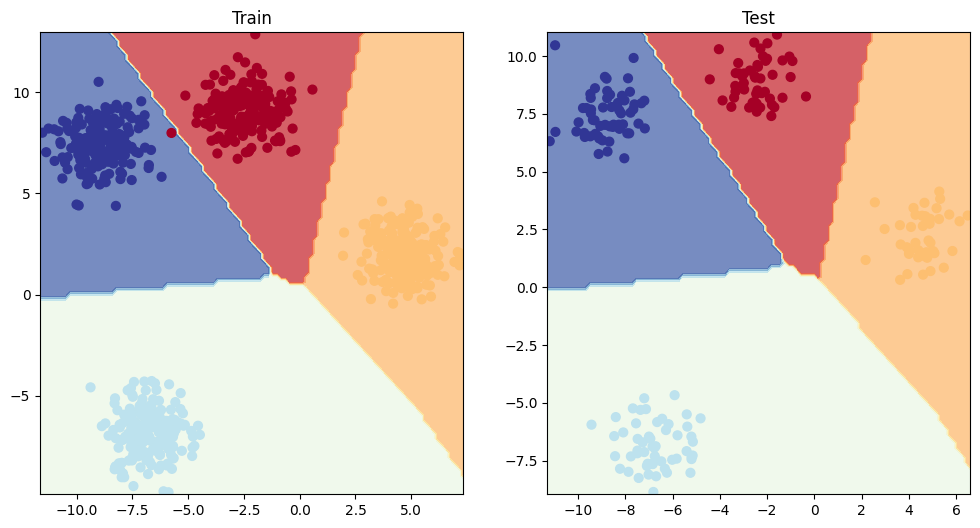

In [125]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, x_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, x_test, y_test)

In [126]:
!pip install torchmetrics

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [136]:
from torchmetrics import Accuracy
accuracy_fn = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
accuracy_fn(y_preds.int(), y_test.int())



tensor(1.)

In [139]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       1.00      1.00      1.00        41
           2       1.00      1.00      1.00        53
           3       1.00      1.00      1.00        57

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

